# Assignment 1 - Image Processing Primer

In [1]:
%pylab inline

import cv2
import numpy as np
import time as t

# Helper function
def swap_and_show(img):
    """ Swaps the color from BGR to RGB mode, for transfer
    of image from cv2 to pylab domain """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
   

Populating the interactive namespace from numpy and matplotlib


## 1. Reading & Displaying Images

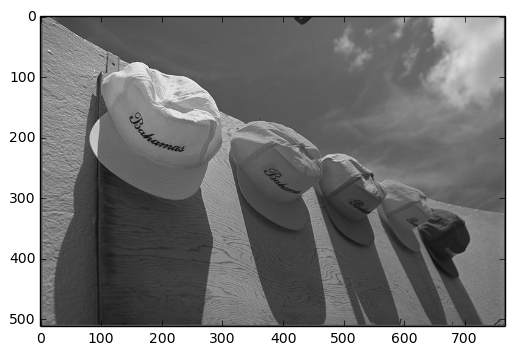

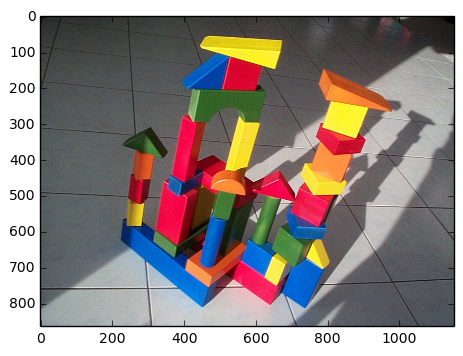

In [2]:
cap_img = cv2.imread("cap.bmp", cv2.IMREAD_COLOR)
lego_img = cv2.imread("lego.tif", cv2.IMREAD_COLOR)

cap_img.shape
figure()
imshow(swap_and_show(cap_img))
figure()
imshow(swap_and_show(lego_img))

## 2. RGB to Grayscale Conversion & Display 

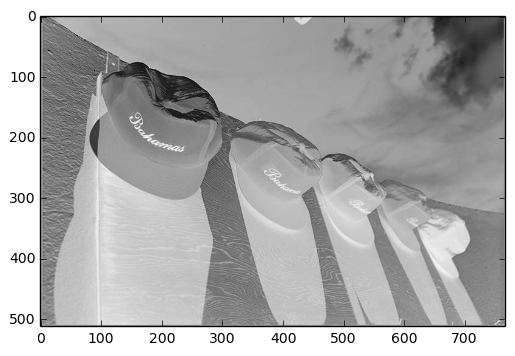

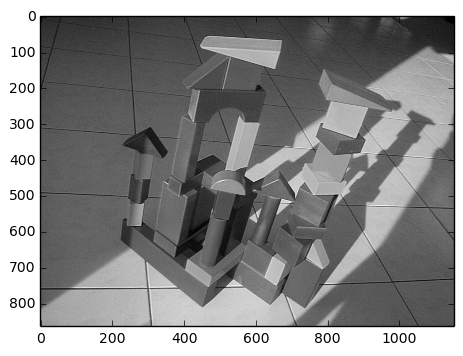

In [3]:
def rgb2gray(img):
    gray = np.mean(img, axis=2)
    pgray = np.array(gray, dtype=np.uint8)
    return gray

gray_cap_img = rgb2gray(cap_img)
gray_lego_img = rgb2gray(lego_img)

figure()
imshow(gray_cap_img, cmap='gray_r')
figure()
imshow(gray_lego_img, cmap='gray')

## 3. Addition of Gaussian Noise, Median & Mean Filtering

In [4]:
import pdb
def noised_image(clean_img, stddev):
    noise = np.zeros(clean_img.shape)
    cv2.randn(noise, (0), (stddev))
    noised_img = noise + clean_img
    noised_img = np.array(noised_img, dtype=np.uint8)
    return noised_img

def mean_filter(img):
    # Return
    nrows, ncols = img.shape
    filtered_image = img
    for row in xrange(1,nrows-1):
        for col in xrange(1,ncols-1):
            filtered_image[row, col] = np.mean(img[row-1:row+2, col-1:col+2])
    filtered_image = np.array(filtered_image, dtype=np.uint8)
    return filtered_image

def median_filter(img):
    # Return
    nrows, ncols = img.shape
    filtered_image = img
    for row in xrange(1,nrows-1):
        for col in xrange(1,ncols-1):
            roi = img[row-1:row+2, col-1:col+2]
            filtered_image[row, col] = np.sort(roi.ravel())[4]
    return filtered_image   


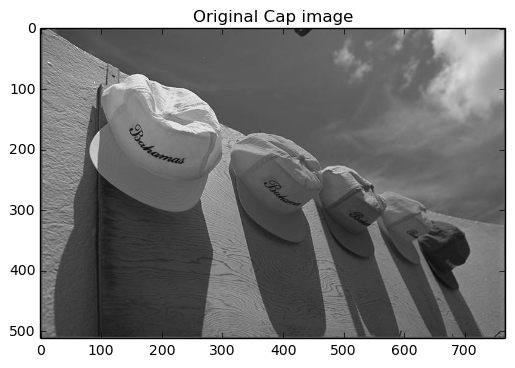

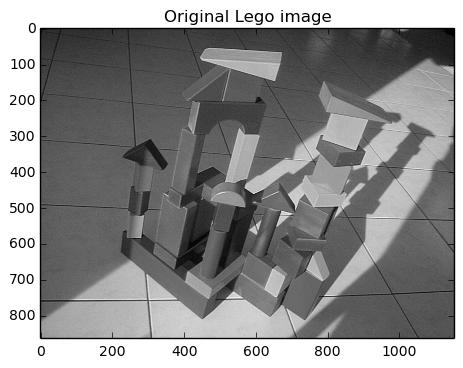

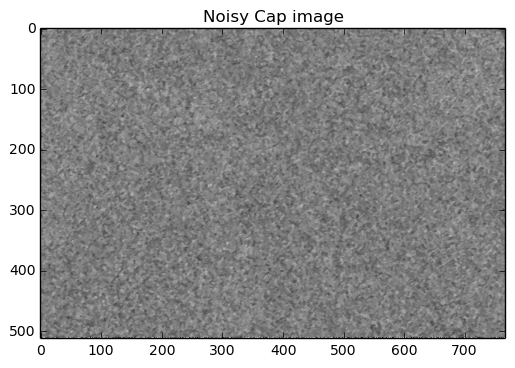

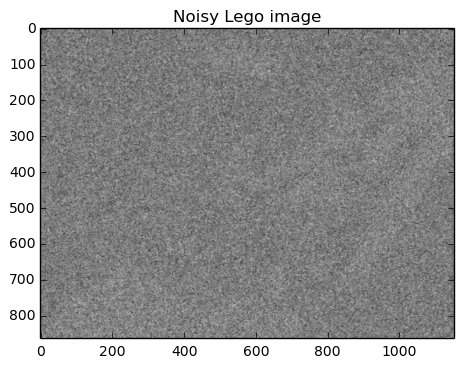

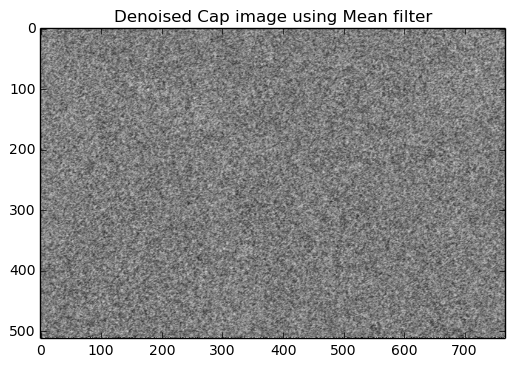

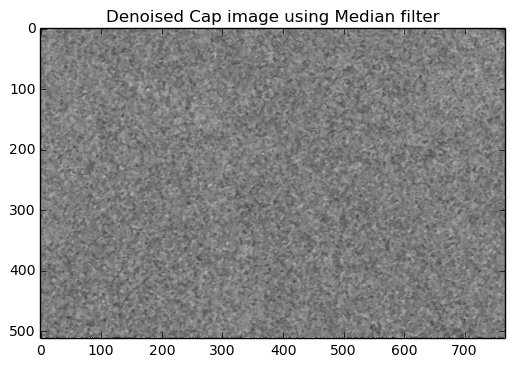

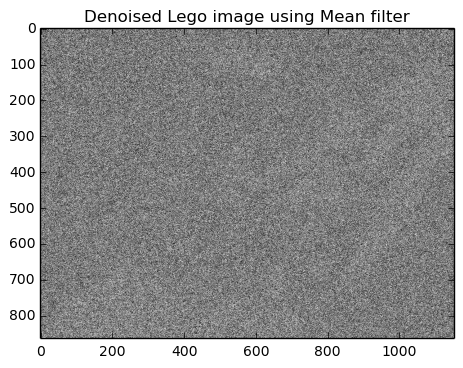

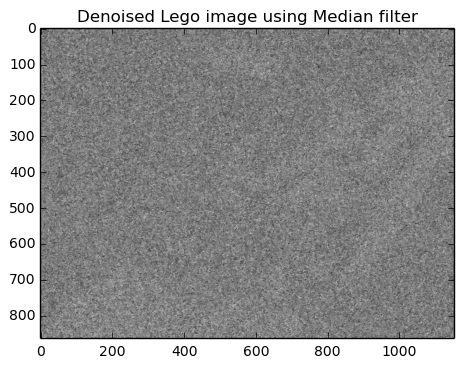

In [5]:
# You can change the value here, and press Shift+Enter to re-run the code
stddev = 99

# Adding noise to the images
noisy_cap_img = noised_image(gray_cap_img, stddev)
noisy_lego_img = noised_image(gray_lego_img, stddev)

# Denoise the images
denoised_cap_img_mean = mean_filter(noisy_cap_img)
denoised_cap_img_median = median_filter(noisy_cap_img)

denoised_lego_img_mean = mean_filter(noisy_lego_img)
denoised_lego_img_median = median_filter(noisy_lego_img)

# Show Original images
figure()
title('Original Cap image')
imshow(gray_cap_img, cmap='gray')
figure()
title('Original Lego image')
imshow(gray_lego_img, cmap='gray')

# Show noisy images
figure()
title('Noisy Cap image')
imshow(noisy_cap_img, cmap='gray')
figure()
title('Noisy Lego image')
imshow(noisy_lego_img, cmap='gray')

# Show denoised images
figure()
title('Denoised Cap image using Mean filter')
imshow(denoised_cap_img_mean, cmap='gray')
figure()
title('Denoised Cap image using Median filter')
imshow(denoised_cap_img_median, cmap='gray')
figure()
title('Denoised Lego image using Mean filter')
imshow(denoised_lego_img_mean, cmap='gray')
figure()
title('Denoised Lego image using Median filter')
imshow(denoised_lego_img_median, cmap='gray')

## 4. PSNR v Standard Deviation of Noise

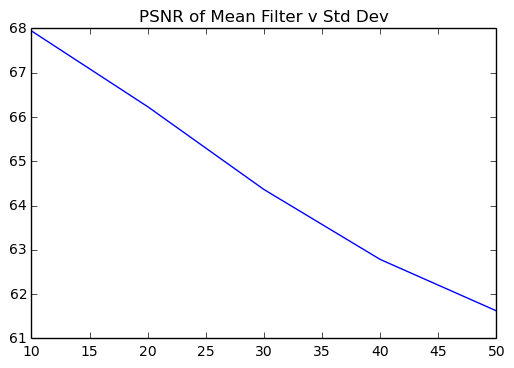

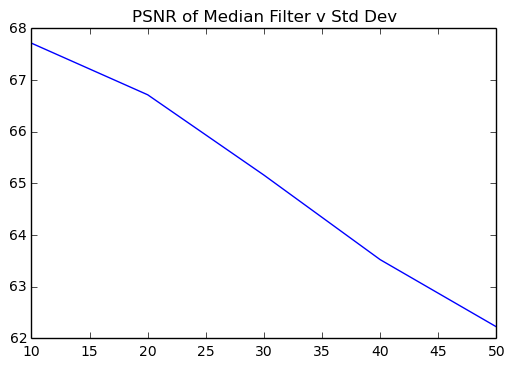

In [6]:
def PSNR(I, K):
    I_max = np.max(I.ravel())
    MSE = np.linalg.norm(I - K) / (I.shape[0] * I.shape[1])
    return 20*np.log10(I_max) - 10*np.log10(MSE)

list_stddev = np.array([10, 20, 30, 40, 50])
psnr_mean, psnr_median = np.zeros(5), np.zeros(5)

for idx, stddev in enumerate(list_stddev):
    noised_image_cap = noised_image(gray_cap_img, stddev)
    denoised_cap_img_mean = mean_filter(noised_image_cap)
    psnr_mean[idx] = PSNR(gray_cap_img, denoised_cap_img_mean)
    
    denoised_cap_img_median = median_filter(noised_image_cap)
    psnr_median[idx] = PSNR(gray_cap_img, denoised_cap_img_median)

figure()
title('PSNR of Mean Filter v Std Dev')
plot(list_stddev, psnr_mean, linewidth=1)

figure()
title('PSNR of Median Filter v Std Dev')
plot(list_stddev, psnr_median, linewidth=1)    

## 5. Edge Pixel Detection using LoG operator

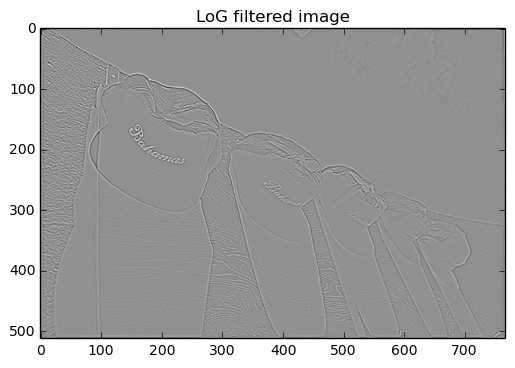

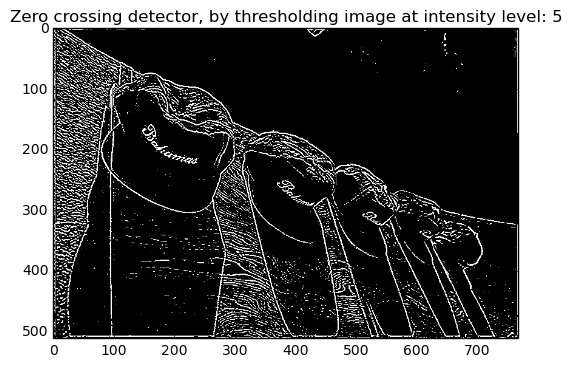

In [7]:
import math

L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
def gaussian_filt(std):
    G = np.zeros((3,3))

    for i in xrange(3):
        for j in xrange(3):
           G[i, j] = (1/2.0*math.pi*std**2)*np.exp(-((i-1)**2+(j-1)**2)/(2.0*std**2)); 
    G = G / np.sum(G)
    return G

# Build a Gaussian filter of std 1
G = gaussian_filt(1)
intermediate_img = cv2.filter2D(gray_cap_img, -1, G)

output_img = cv2.filter2D(intermediate_img, -1, L)
figure()
title('LoG filtered image')
imshow(output_img, cmap='gray')

# Detecting zero crossings
edge_map = (output_img >= 5)
figure()
title('Zero crossing detector, by thresholding image at intensity level: 5')
imshow(edge_map, cmap='gray')


## 6. DCT & IDCT

[[  97.  103.   94. ...,  107.   95.  101.]
 [  96.  105.  102. ...,  104.   97.  105.]
 [ 103.  105.   99. ...,   93.   92.  101.]
 ..., 
 [  99.   98.   98. ...,   95.   98.  101.]
 [  99.   99.   99. ...,  102.   97.   95.]
 [ 101.   99.   99. ...,   98.   99.  103.]]
[[  7.62691168e+05  -2.61853535e+05   1.77540161e+05 ...,   1.79418580e+05
   -2.61742389e+05   7.64361310e+05]
 [  1.95186615e+05  -7.29988576e+01   1.10002373e+05 ...,   1.16564826e+05
    1.65177722e+03   1.96952427e+05]
 [ -4.81036055e+04  -2.47133095e+04   2.30876406e+04 ...,   2.37193965e+04
   -2.67544814e+04  -4.80945295e+04]
 ..., 
 [  3.61875663e+05  -1.18384765e+05   1.01852955e+05 ...,   1.04339771e+05
   -1.20041642e+05   3.62111832e+05]
 [  2.46678290e+05   1.09433357e+04   9.72610094e+04 ...,   1.03690377e+05
    1.27518229e+04   2.47107987e+05]
 [  1.13261255e+06  -3.61951848e+05   2.43290936e+05 ...,   2.45236133e+05
   -3.62766240e+05   1.13261500e+06]]
[[ True  True  True ...,  True  True  True]
 [ T

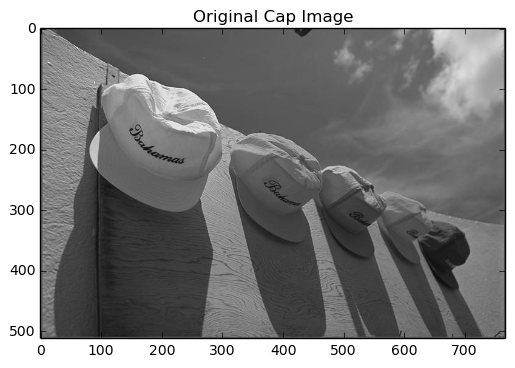

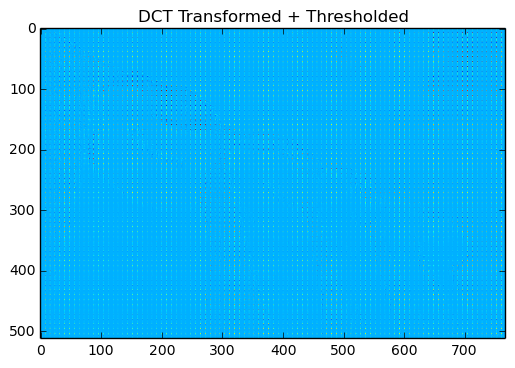

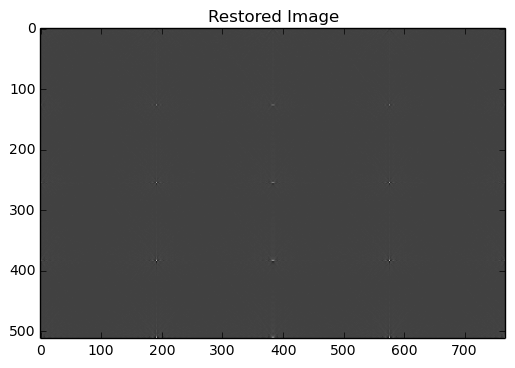

In [15]:
def dct_2D(x):
    M, N = x.shape
    W_M, W_N = np.zeros((M, M)), np.zeros((N, N))
    for i in xrange(M):
        for k in xrange(M):
            W_M[i, k] = np.cos(math.pi*(i+0.5)*k/M)
    W_M /= M
    for i in xrange(N):
        for k in xrange(N):
            W_N[i, k] = np.cos(math.pi*(i+0.5)*k/N)
    W_N /= N
    X = np.dot(W_M, x)
    X = np.dot(X, W_N)
    return X

def idct_2D(X):
    M, N = X.shape
    W_M, W_N = np.zeros((M, M)), np.zeros((N, N))
    for i in xrange(M):
        for k in xrange(M):
            W_M[i, k] = np.cos(math.pi*(i+0.5)*k/M)
    W_M /= M
    for i in xrange(N):
        for k in xrange(N):
            W_N[i, k] = np.cos(math.pi*(i+0.5)*k/N)
    W_N /= N
    W_M_inv = np.linalg.inv(W_M)
    W_N_inv = np.linalg.inv(W_N)
    
    x = np.dot(W_M_inv, X)
    x = np.dot(x, W_N_inv)
    
    return x
    
# Conduct chunking of the image into 8X8 blocks
nrows, ncols = gray_cap_img.shape

del_rows, del_cols = 0, 0
if nrows % 8 != 0:
    del_rows = 8 - nrows%8
if ncols % 8 != 0:
    del_cols = 8 - ncols%8

img = np.lib.pad(gray_cap_img, (del_rows, del_cols), 'constant', constant_values=(0, 0))

nrow_chunks, ncol_chunks = (nrows+del_rows)/8, (ncols+del_cols)/8

low_thresh, mid_thresh, high_thresh = -256*8, -256*8, -256*8
mask_array_low, mask_array_high, mask_array_mid = np.zeros((8,8)), np.zeros((8,8)), np.zeros((8,8))

overall, raw = np.zeros(img.shape), np.zeros(img.shape)

for i in xrange(8):
    for k in xrange(8):
        if (i+k) < 6:
            mask_array_low[i, k] = 1
        elif (i+k) < 10:
            mask_array_mid[i, k] = 1
        else:
            mask_array_high[i, k] = 1
            
for r in xrange(nrow_chunks):
    for c in xrange(ncol_chunks):
        tmp = dct_2D(img[r*8:(r+1)*8, c*8:(c+1)*8])
        
        raw[r*8:(r+1)*8, c*8:(c+1)*8] = tmp
        
        # Dot product to test thresholding
        tmp_low = tmp * mask_array_low
        tmp_low = (tmp_low >= low_thresh) * tmp_low
        
        tmp_mid = tmp * mask_array_mid
        tmp_mid = (tmp_mid >= mid_thresh) * tmp_mid
        
        tmp_high = tmp * mask_array_high
        tmp_high = (tmp_high >= high_thresh) * tmp_high
        
        # Composing the thresholded freq components
        proc_tmp = tmp_low + tmp_mid + tmp_high
        
        overall[r*8: (r+1)*8, c*8:(c+1)*8] = proc_tmp
        
        proc_img[r*8: (r+1)*8, c*8: (c+1)*8] = idct_2D(overall)

figure()
title('Original Cap Image')
imshow(img, cmap='gray')

figure()
title('DCT Transformed + Thresholded')
imshow(proc_img)

figure()
title('Restored Image')
imshow(proc_img, cmap='gray')

## 7. Harris Corner Detection Algorithm


In [ ]:
# Set the threshold here.
threshold = 5000

# Following algorithm from http://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf

kernel_dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
kernel_dy = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

# Computing derivatives
I_x = cv2.filter2D(gray_lego_img, -1, kernel_dx)
I_y = cv2.filter2D(gray_lego_img, -1, kernel_dy)

# Computing products of the derivatives
I_x2 = I_x * I_x
I_y2 = I_y * I_y
I_xy = I_x * I_y

# After this, for choosing 'w', we can choose either all 1s or some custom function.
# Here, we choose Gaussian weighted kernel coefficients
w = gaussian_filt(1)

# Elements of the H matrix formed for every pixel
S_x2 = cv2.filter2D(I_x2, -1, w)
S_xy = cv2.filter2D(I_xy, -1, w)
S_y2 = cv2.filter2D(I_y2, -1, w)

# Using Noble's corner measure here: https://en.wikipedia.org/wiki/Corner_detection#The_Harris_.26_Stephens_.2F_Plessey_.2F_Shi.E2.80.93Tomasi_corner_detection_algorithms
eps = np.finfo(np.float32).eps
det_H = S_x2 * S_y2 - S_xy * S_xy
trace_H = S_x2 + S_y2

Mc = 2 * det_H / (trace_H + eps)
print "Range of Mc is {} - {}".format(Mc.min(), Mc.max())

# Test for thresholds, and plot them.
row_idx, col_idx = np.where(Mc > threshold)

figure()
imshow(gray_lego_img, cmap='gray')
for idx, _ in enumerate(row_idx):
    scatter([col_idx[idx]], [row_idx[idx]])
show()

